In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import re

pd.options.display.max_columns = 999
pd.options.display.max_rows = 300
np.set_printoptions(linewidth=400)
%matplotlib inline
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [41]:
players = pd.read_csv("CompleteDataset.csv")
player_att = pd.read_csv("PlayerAttributeData.csv") #to get att names easier

/Users/matt/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/matt/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
players["Wage"] = players["Wage"].replace('[\€K,]', '', regex=True).astype(float)
players["Wage log"] = players["Wage"].apply(np.log)
players["Wage log"] = players["Wage log"].fillna(0)
players["Preferred Positions 1"] = players["Preferred Positions"].apply(lambda x: re.findall('^([\w\-]+)', x)[0])
positions_unique = players["Preferred Positions 1"].unique()
positions_int = range(len(positions_unique))
# if fowards 0, midfield = 1, defender = 2, GK = 3
positions_map1 = {
 'CAM': 1,
 'CB': 2,
 'CDM': 2,
 'CF': 0,
 'CM': 1,
 'GK': 3,
 'LB': 2,
 'LM': 1,
 'LW': 0,
 'LWB': 2,
 'RB': 2,
 'RM': 1,
 'RW': 0,
 'RWB': 2,
 'ST': 0}
positions_map2 = dict(zip(positions_unique,positions_int))
attribute_names = player_att.columns[1:].values
players["Preferred Positions int"] = players["Preferred Positions 1"].replace(positions_map1)
#players = players[players["Preferred Positions 1"]!="GK"] # remove GKs

In [44]:
players = players.fillna(players.mean())
attributes = players[attribute_names]
attributes = attributes.apply(pd.to_numeric, errors='coerce', axis=0)
names = attributes.columns.values
attributes = attributes.fillna(attributes.mean())

In [45]:
scaler = StandardScaler()
attributes = scaler.fit_transform(attributes)
dim_reduce = PCA(n_components=2)
dim_reduce_fit = dim_reduce.fit_transform(attributes)
print(dim_reduce.explained_variance_ratio_)

[0.53614229 0.14375677]


In [46]:
col = (players["Preferred Positions 1"] != "GK")*1
col = col.apply(lambda x: "red" if x==True else "blue")
col = players["Preferred Positions int"]

In [58]:
def myplot(score,coeff,labels=None,color="blue"):
    fig, ax = plt.subplots(figsize=(20,20))
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    cax = ax.scatter(xs*scalex,ys*scaley,c = color)
    arrow_scale = 2.3
    for i in range(n):
        ax.arrow(0, 0, coeff[i,0]*arrow_scale, coeff[i,1]*arrow_scale,color = 'r',alpha = 0.5)
        ax.text(coeff[i,0]*arrow_scale, coeff[i,1]*arrow_scale, labels[i], color = 'g', ha = 'center', va = 'center')

    cbar = fig.colorbar(cax, ticks=[0,1,2,3], orientation='horizontal')
    cbar.ax.set_xticklabels(['Foward','Midfield','Defender',"Goalkeeper"])  # horizontal colorbar
    plt.show()

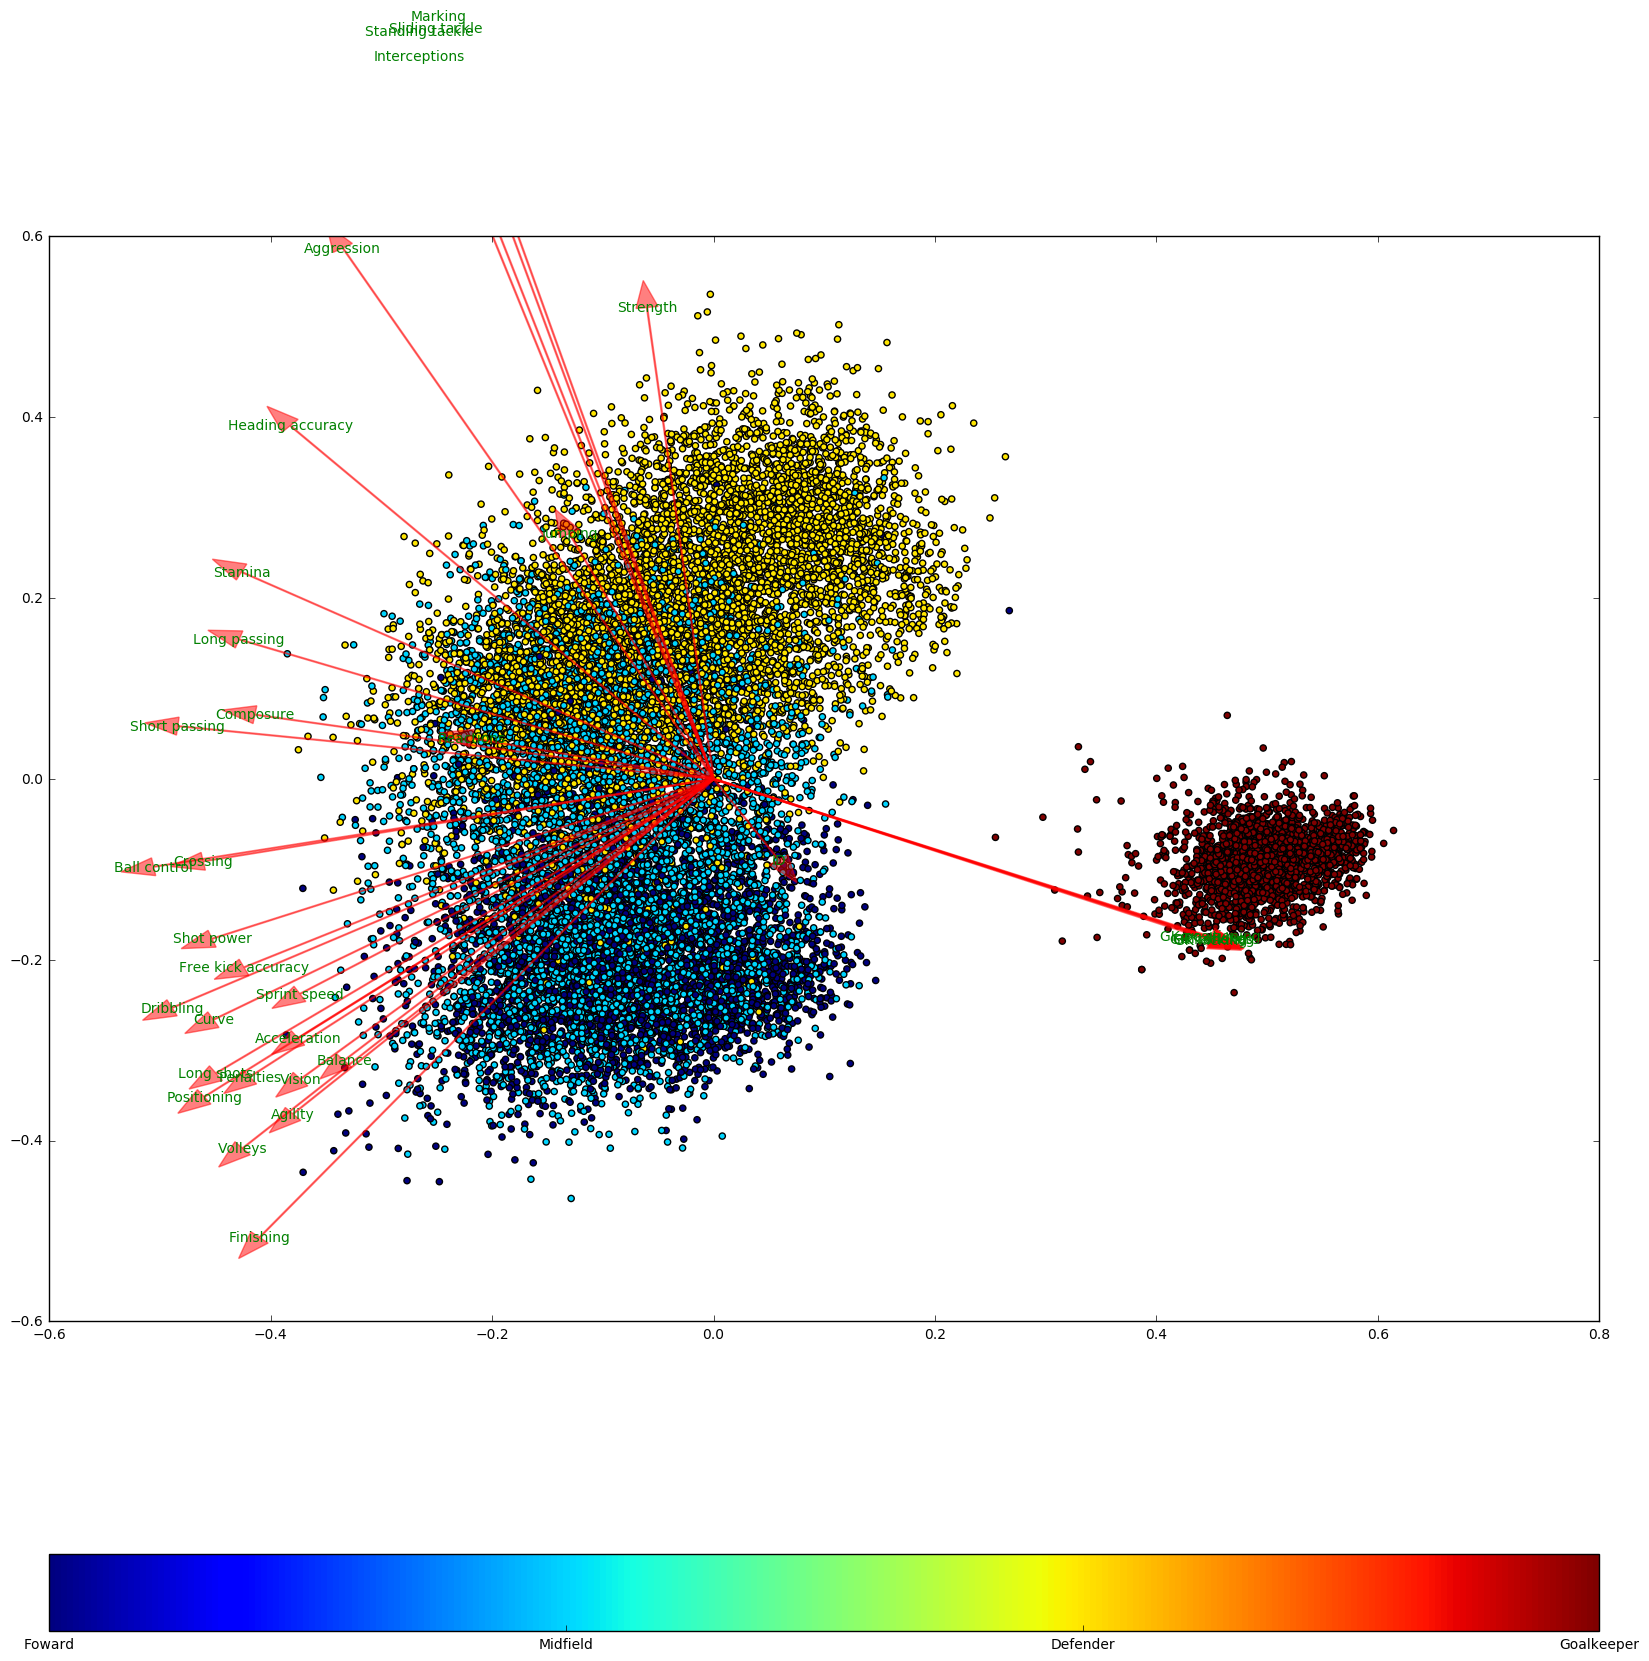

In [59]:
myplot(dim_reduce_fit,np.transpose(dim_reduce.components_[0:2, :]),labels=names,color=col)


# Remove GKs 

In [ ]:
attributes_keep = list(filter(lambda name: 'GK' not in name,attribute_names)) # remove goalkeeping skills
attributes_keep.remove('ID')

# Expensive players

In [ ]:
wage = players["Wage"]
wage_cut_off = 0
f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)
ax1.hist(wage,bins=20); 
ax2.hist(wage[wage>wage_cut_off],bins=20); 
plt.show()
players = players[players["Wage"]>wage_cut_off]